In [299]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

## Now we load and preprocess some images 

In [300]:
def load_and_preprocess_images(train_cat_dir, train_noncat_dir, test_cat_dir, test_noncat_dir, image_size=(64, 64)):
    """
    Load and preprocess images from directories.
    Arguments:
        train_cat_dir: Path to training cat images
        train_noncat_dir: Path to training non-cat images
        test_cat_dir: Path to test cat images
        test_noncat_dir: Path to test non-cat images
        image_size: Tuple of (height, width) for resizing
    Returns:
        train_set_x, train_set_y, test_set_x, test_set_y, classes
    """
    def process_image(directory, label, image_size):
        images = []
        labels = []
        for filename in os.listdir(directory):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(directory, filename)
                img = Image.open(img_path).convert('RGB').resize(image_size)
                img_array = np.array(img) / 255.0  # Normalize
                images.append(img_array.flatten())
                labels.append(label)
        return np.array(images).T, np.array(labels).reshape(1, -1)

    # Process training and test sets
    train_cat_x, train_cat_y = process_image(train_cat_dir, 1, image_size)
    train_noncat_x, train_noncat_y = process_image(train_noncat_dir, 0, image_size)
    test_cat_x, test_cat_y = process_image(test_cat_dir, 1, image_size)
    test_noncat_x, test_noncat_y = process_image(test_noncat_dir, 0, image_size)

    # Combine cat and non-cat data
    train_set_x = np.hstack((train_cat_x, train_noncat_x))
    train_set_y = np.hstack((train_cat_y, train_noncat_y))
    test_set_x = np.hstack((test_cat_x, test_noncat_x))
    test_set_y = np.hstack((test_cat_y, test_noncat_y))

    classes = np.array(['non-cat', 'cat'])
    return train_set_x, train_set_y, test_set_x, test_set_y, classes

## The Sigmoid Function

In [301]:
def sigmoid(z):
    """
    ARguments:
        z: a scalar or numpy array
    Returns:
        sigmoid(z): the sigmoid of z
    """
    return 1 / (1 + np.exp(-z))

## Initialize the Parameters with ZEROS

In [302]:
def initialize_with_zeros(dim):
    """
    Initialize a 2D array with zeros.
    Arguments:
        dim (tuple): The dimensions of the array. This is also the Number of Features(i.e num_px * num_px * 3) in the problem statement.
    Returns:
        array: A 2D array with zeros.
    """
    w = np.zeros((dim, 1))
    b = 0.0
    return w, b

## Forward and Backward Propagation Code

In [303]:
def propagate(w, b, X, Y):
    """ 
    Calculate the gradient and the cost
    Arguments:
        w = weights, a numpy array of size (number of features,)
        b = bias, a numpy array of size (1,)
        X = input data, a numpy array of size (number of samples, number of features), shape (num_px * num_px * 3, m)
        Y = output data, a numpy array of size (number of samples,), shape (1, m)

    Returns:
        dW = gradient of the cost with respect to w, Dictionary with gradients (dw, db)
        db = gradient of the cost with respect to b, Negative log-likelihood cost
    """

    m = X.shape[1]  # Number of samples, not features
    # Forward pass
    A = sigmoid(np.dot(w.T, X) + b)
    # Cost function with epsilon to avoid log(0)
    cost = - (1 / m) * np.sum(Y * np.log(A + 1e-15) + (1 - Y) * np.log(1 - A + 1e-15))
    # Backward Pass
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    # These were written for debugging process only

    # print(f"X shape: {X.shape}, Y shape: {Y.shape}, A shape: {A.shape}")  # Shape check
    # print(f"A - Y mean: {np.mean(A - Y)}, A - Y norm: {np.linalg.norm(A - Y)}")  # Error magnitude
    # print(f"dw shape: {dw.shape}, dw norm: {np.linalg.norm(dw)}")  # Gradient magnitude
    # print(f"db: {db}")  # Bias gradient
    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw, "db": db}
    return grads, cost

## Optimizing the algorithm with Gradient Descent

In [304]:
def optimization(w, b, X, Y, learning_rate = 0.005, iterations = 2000, print_cost = False):
    """
    This function optimizes the parameters w and b for a given dataset X and Y
    using gradient descent.
    Arguments:
        w = weights, initialized by zeros
        b = bias, initialized by zeros
        X = data, a matrix where each row is a data point
        Y = target variable, a vector where each element is the target for a data point
        learning_rate = the step size at each iteration
        iterations = the number of iterations to perform gradient descent
        print_cost = a boolean to print the cost every 100 iterations
    Returns:
        parameters = the optimized parameters w and b
    """
    costs = []
    w = w.copy()
    b = b

    # initialize dw and db
    # I am getting errors without doing ths
    # This ensures dw and db are defined even if
    # the loop is skipped (e.g., if iterations=0).
    dw = np.zeros(w.shape)
    db = 0

    iterations = int(iterations)
    for i in range(iterations):
        # Forward pass
        grads, cost = propagate(w,b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost}")
                print(f"Step {i} - w norm: {np.linalg.norm(w)}, b: {b}")  # Track updates
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    return params, grads, costs

## The Prediction Function

In [305]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using the learned Logistic Regression parameters(w, b)
    Arguments:
        w (numpy array): Weights of the model
        b (float): Bias of the model
        X (numpy array): Input features
    Returns:
        y_pred (numpy array): Predicted labels
    """
    m = X.shape[1]
    y_pred = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Now here the vector "A" is predicted
    # The probabilities of the pic being a cat that is

    A = sigmoid(np.dot(w.T, X) + b)

    # Debugging code only, 
    # print(f"Probability A: {A[0, 0]}")   Should vary >0.5 or <0.5
    # print(f"Weight norm: {np.linalg.norm(w)}")   Should be non-zero
    # print(f"Bias: {b}")   Should adjust from 0.0

    # Converting the probabilites A[0, i] to 0 or 1 using iteration
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            y_pred[0, i] = 1.0
        else:
            y_pred[0, i] = 0.0

    return y_pred

### Checking if things are working so far

In [306]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## Building the Logistic Regression

### Merging all the functions we have created so far here 


In [307]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.005, iterations=2000, print_cost=False):
    """
    Building the logistics Regression model
    Arguments:
        X_train -- training set
        Y_train -- training set
        X_test -- test set
        Y_test -- test set
        iterations -- number of iterations of the model
        learning_rate -- learning rate of the model
        print_cost -- whether to print the cost or not
    Returns:
        d -- dictionary containing information about the model
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimization(w, b, X_train, Y_train, learning_rate, iterations, print_cost)
    w = params["w"]
    b = params["b"]
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    if print_cost:
        print(f"train accuracy: {100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100} %")
        print(f"test accuracy: {100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100} %")
    d = {"costs": costs, "w": w, "b": b, "learning_rate": learning_rate}
    return d

## Loading and Training the Data

In [308]:
# Guideline 8: Load Data and Train Model
train_cat_dir = "images/cats/train/"
train_noncat_dir = "images/non-cats/train/"
test_cat_dir = "images/cats/test/"
test_noncat_dir = "images/non-cats/test/"

train_set_x, train_set_y, test_set_x, test_set_y, classes = load_and_preprocess_images(
    train_cat_dir, train_noncat_dir, test_cat_dir, test_noncat_dir
)

# Verify shapes
print(f"train_set_x shape: {train_set_x.shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x shape: {test_set_x.shape}")
print(f"test_set_y shape: {test_set_y.shape}")

train_set_x shape: (12288, 58)
train_set_y shape: (1, 58)
test_set_x shape: (12288, 11)
test_set_y shape: (1, 11)


In [309]:
# Train the model
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.6931471805599433
Step 0 - w norm: 0.016881653502098803, b: -0.0002586206896551724
Cost after iteration 100: 0.26479683296948897
Step 100 - w norm: 0.41349466871885837, b: -0.011884898001969282
Cost after iteration 200: 0.1842648194613339
Step 200 - w norm: 0.5948105199538759, b: -0.021080136768964912
Cost after iteration 300: 0.14142093463822447
Step 300 - w norm: 0.7317934855974886, b: -0.028211969113643157
Cost after iteration 400: 0.1145300277399642
Step 400 - w norm: 0.8411018295291489, b: -0.034264705439516714
Cost after iteration 500: 0.09603620206750517
Step 500 - w norm: 0.9320152575398115, b: -0.03959621193436092
Cost after iteration 600: 0.08253367193705632
Step 600 - w norm: 1.0098283374199357, b: -0.04438234599288812
Cost after iteration 700: 0.07224701395352184
Step 700 - w norm: 1.077833365064842, b: -0.048727210299098205
Cost after iteration 800: 0.06415627409173802
Step 800 - w norm: 1.1382160530323278, b: -0.052701442016587434
Cost after itera

In [ ]:
def propagate(w, b, X, Y):
    """ 
    Calculate the gradient and the cost
    Arguments:
        w = weights, a numpy array of size (number of features,)
        b = bias, a numpy array of size (1,)
        X = input data, a numpy array of size (number of samples, number of features), shape (num_px * num_px * 3, m)
        Y = output data, a numpy array of size (number of samples,), shape (1, m)

    Returns:
        dW = gradient of the cost with respect to w, Dictionary with gradients (dw, db)
        db = gradient of the cost with respect to b, Negative log-likelihood cost
    """

    m = X.shape[1]  # Number of samples, not features
    # Forward pass
    A = sigmoid(np.dot(w.T, X) + b)
    # Cost function with epsilon to avoid log(0)
    cost = - (1 / m) * np.sum(Y * np.log(A + 1e-15) + (1 - Y) * np.log(1 - A + 1e-15))
    # Backward Pass
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    # These were written for debugging process only

    # print(f"X shape: {X.shape}, Y shape: {Y.shape}, A shape: {A.shape}")  # Shape check
    # print(f"A - Y mean: {np.mean(A - Y)}, A - Y norm: {np.linalg.norm(A - Y)}")  # Error magnitude
    # print(f"dw shape: {dw.shape}, dw norm: {np.linalg.norm(dw)}")  # Gradient magnitude
    # print(f"db: {db}")  # Bias gradient
    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw, "db": db}
    return grads, cost

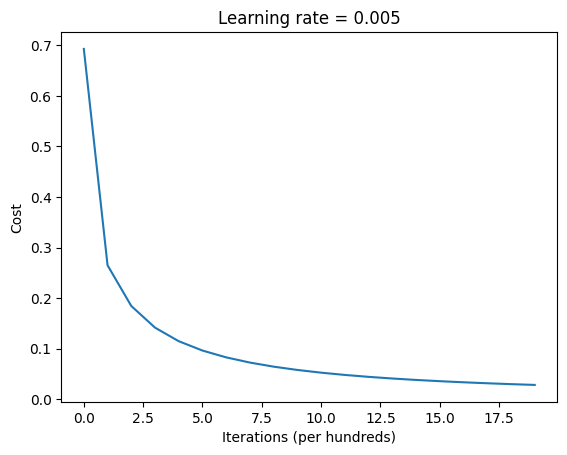

In [310]:
# Visualize Learning Curve
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title(f"Learning rate = {logistic_regression_model['learning_rate']}")
plt.show()


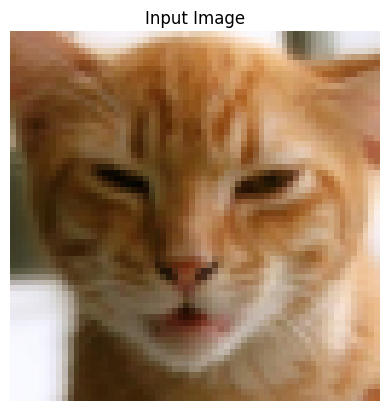

Image shape: (12288, 1)
y = 1.0, predicted: cat


In [311]:
# Test with a Custom Image
my_image = "my_image.png"  
image_path = os.path.join("images/", my_image)

try:
    # Load and display the image
    image = Image.open(image_path).convert('RGB').resize((64, 64))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title("Input Image")
    plt.show()

    # Preprocess the image for prediction
    image_array = np.array(image) / 255.0
    image_array = image_array.reshape((1, 64 * 64 * 3)).T
    print(f"Image shape: {image_array.shape}")

    # Make prediction
    my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image_array)
    print(f"y = {np.squeeze(my_predicted_image)}, predicted: {classes[int(np.squeeze(my_predicted_image))]}")

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure {image_path} exists and is accessible.")
except Exception as e:
    print(f"An error occurred: {e}")

In [312]:
print(np.unique(train_set_y, return_counts=True))

(array([0, 1]), array([32, 26], dtype=int64))


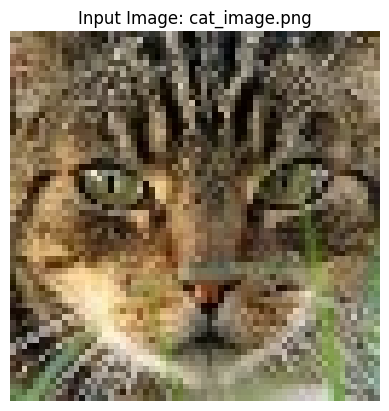

Image shape: (12288, 1)
Probability A: 0.9924461211813732
y = 1.0, predicted: cat


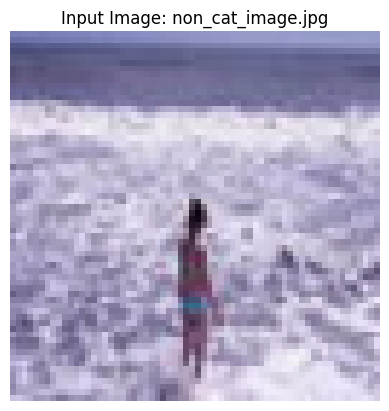

Image shape: (12288, 1)
Probability A: 0.026190817153443582
y = 0.0, predicted: non-cat


In [313]:
for my_image in ["cat_image.png", "non_cat_image.jpg"]:
    image_path = os.path.join("images/", my_image)
    try:
        image = Image.open(image_path).convert('RGB').resize((64, 64))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Input Image: {my_image}")
        plt.show()
        image_array = np.array(image) / 255.0
        image_array = image_array.reshape((1, 64 * 64 * 3)).T
        print(f"Image shape: {image_array.shape}")
        my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image_array)
        print(f"Probability A: {sigmoid(np.dot(logistic_regression_model['w'].T, image_array) + logistic_regression_model['b'])[0, 0]}")
        print(f"y = {np.squeeze(my_predicted_image)}, predicted: {classes[int(np.squeeze(my_predicted_image))]}")
    except Exception as e:
        print(f"Error: {e}")